<a href="https://colab.research.google.com/github/maksim267/Attention_and_transformers_for_clasification/blob/main/Copy_of_%5Bhomework%5DAttention_and_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [1]:
pip install -U "transformers>=4.35.0" "huggingface-hub>=0.18.0"

  Using cached huggingface_hub-1.1.2-py3-none-any.whl.metadata (13 kB)


In [2]:
!pip install accelerate -U

In [3]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [4]:
import numpy as np
import transformers, huggingface_hub
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
from tqdm.auto import tqdm
from typing import Union
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
import copy


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [7]:
df = pd.read_csv('/content/gdrive/My Drive/data_problems_translated.xlsx - Sheet1.csv')

In [8]:
df

,Unnamed: 0,problem_text,topic
0,0,To prove that the sum of the numbers of the ex...,number_theory
1,1,( b) Will the statement of the previous challe...,number_theory
2,2,The quadratic three-member graph with the coef...,polynoms
3,3,Can you draw on the surface of Rubik's cube a ...,combinatorics
4,4,"Dima, who came from Vrunlandia, said that ther...",graphs
...,...,...,...
5268,5268,Can the number n! end with the figures of 76.0...,number_theory
5269,5269,Find all natural m and n for which m! + 12 = n2.,number_theory
5270,5270,"The correct 5,000-column has a 2001 vertebrate...",dirichlet
5271,5271,Find the maximum number N for which there are ...,number_theory


In [9]:
df.topic.value_counts()

,count
topic,
number_theory,2396
combinatorics,1020
dirichlet,441
polynoms,426
graphs,384
geometry,371
invariant,235


### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [10]:
### This is just an interface example. You may change it if you want.


class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module],hidden_dim=256,num_class=7):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(base_transformer_model)
        self.text_proj = nn.Linear(self.backbone.config.hidden_size, hidden_dim)

        self.classifire_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_class),
            # nn.Softmax(dim=1)
        )

    def forward(self, inputs):
        # YOUR CODE: propagate inputs through the model. Return dict with logits
        text_from_t=self.backbone(inputs['input_ids'], attention_mask=inputs['attention_mask'])
        cls_embedding = text_from_t.last_hidden_state[:, 0, :]
        logits=self.classifire_head(self.text_proj(cls_embedding))

        return logits

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [11]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [12]:
class Dataset_text(Dataset):
  def __init__(self,df,le,tokenizer,max_len=128):
    self.df=df.reset_index(drop=True)
    self.tokenizer = tokenizer
    self.max_len=max_len
    self.le=le
  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    encoding=self.tokenizer(
            row['problem_text'],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
    label = self.le.transform([row['topic']])#[0]
    return {
        'input_ids': encoding['input_ids'].squeeze(0).to(device),
        'attention_mask': encoding['attention_mask'].squeeze(0).to(device),
        'targets':torch.tensor(label, dtype=torch.long).to(device)}

In [13]:
def evaluate(model, eval_dataloader, loss_fn=None):
    model.eval()
    predictions, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(next(model.parameters()).device) for k, v in batch.items()}
            logits = model(batch)
            if loss_fn:
                total_loss += loss_fn(logits, batch['targets'].squeeze()).item()
            predictions.append(logits.argmax(dim=1).cpu())
            targets.append(batch['targets'].cpu())

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    acc = (predictions == targets).float().mean().item()
    avg_loss = total_loss / len(eval_dataloader) if loss_fn else None
    return acc, avg_loss


In [14]:

def train_transformer(base_model, dataloader, optimizer_base, loss, freeze=True, num_epoch=10, eval_dataloader=None):
    device = next(base_model.parameters()).device
    model=base_model.to(device)
    optimizer = optimizer_base(model.parameters())
    if freeze==True: freeze_backbone_function(model)
    list_train_loss=[]
    list_eval_acc=[]
    list_train_acc=[]
    list_eval_loss=[]
    for epoch in tqdm(range(num_epoch)):
        model.train()
        total_loss = 0
        batch_count=0
        for batch in dataloader:
            optimizer.zero_grad()
            loges = model(inputs=batch)
            loss_ep = loss(loges, batch['targets'].squeeze() )
            loss_ep.backward()
            optimizer.step()

            total_loss += loss_ep.item()
            batch_count += 1
        if eval_dataloader!=None:
            acc_eval, loss_eval=evaluate(model,eval_dataloader,loss_fn=loss)
        else:
            acc_eval, loss_eval=('Скор на валидации не определен','Скор на валидации не определен')
        acc_train, _=evaluate(model,dataloader)

        list_train_loss.append(total_loss/batch_count)
        list_eval_loss.append(loss_eval)
        list_eval_acc.append(acc_eval)
        list_train_acc.append(acc_train)


        print(f'Epoch {batch_count}')
        print(f'Train loss: {list_train_loss[-1]}, Evalidation loss: {loss_eval}')
        # print(f'Train accuracy: {acc_train}, Evaluation accuracy: {acc_eval}')
        statistic={
            "Train_loss":list_train_loss,
            'Evalidation_loss':list_eval_loss,
            # 'Train_accuracy':list_train_acc,
            # 'Evalidaton_accyracy': list_eval_acc
        }
    return statistic, model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [15]:
le = LabelEncoder()
le.fit(df['topic'])

train_sentences, eval_sentences = train_test_split(df, test_size=0.2)

# eval_sentences=eval_sentences[eval_sentences.topic != 'number_theory']
# train_sentences=train_sentences[train_sentences.topic != 'number_theory']

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')

train_ds=Dataset_text(train_sentences,le,tokenizer)
eval_ds=Dataset_text(eval_sentences,le,tokenizer)

batch_size=32
train_dataloader = DataLoader(
    train_ds,batch_size=batch_size)
eval_dataloader = DataLoader(
    eval_ds, batch_size=batch_size)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
rubert_tiny_transformer_model = TransformerClassificationModel(base_transformer_model='cointegrated/rubert-tiny2',).to(device)
learning_rate=2e-5
loss=nn.CrossEntropyLoss()
optimizer = lambda params: optim.Adam(params, lr=learning_rate)

In [17]:
statistic_fb_1_f, finetuned_1_with_freezed_backbone = train_transformer(base_model=rubert_tiny_transformer_model,
                                                                                     dataloader=train_dataloader,
                                                                                     loss=loss,
                                                                                     freeze=True,
                                                                                     optimizer_base=optimizer,
                                                                                     eval_dataloader=eval_dataloader,
                                                                                     num_epoch=1)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 132
Train loss: 1.85173397082271, Evalidation loss: 1.7659563946001458


In [18]:
rubert_tiny_transformer_model = TransformerClassificationModel(base_transformer_model='cointegrated/rubert-tiny2',).to(device)
statistic_fb_1_wf, finetuned_1_with_full_laier = train_transformer(base_model=rubert_tiny_transformer_model,
                                              dataloader=train_dataloader,
                                              optimizer_base=optimizer,
                                              loss=loss,
                                              eval_dataloader=eval_dataloader, freeze=False,
                                               num_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 132
Train loss: 1.7313319038261066, Evalidation loss: 1.6125122055862888
Epoch 132
Train loss: 1.5031431163802291, Evalidation loss: 1.417230613303907
Epoch 132
Train loss: 1.3163065991618417, Evalidation loss: 1.2623700355038499
Epoch 132
Train loss: 1.1742562145897837, Evalidation loss: 1.1564888990286626
Epoch 132
Train loss: 1.0702314173633403, Evalidation loss: 1.107372643369617
Epoch 132
Train loss: 0.9902898145444465, Evalidation loss: 1.0755231759764932
Epoch 132
Train loss: 0.9303928216298422, Evalidation loss: 1.0675338958248948
Epoch 132
Train loss: 0.8855374468998476, Evalidation loss: 1.0657646493478254
Epoch 132
Train loss: 0.8300069692459974, Evalidation loss: 1.0737007368694653
Epoch 132
Train loss: 0.7868168825904528, Evalidation loss: 1.0946934241237063


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [19]:
### YOUR CODE IS HERE (probably, similar on the previous step)

In [20]:
tokenizer = AutoTokenizer.from_pretrained('tbs17/MathBert')

train_ds=Dataset_text(train_sentences,le,tokenizer)
eval_ds=Dataset_text(eval_sentences,le,tokenizer)

batch_size=32
train_dataloader = DataLoader(
    train_ds,batch_size=batch_size)
eval_dataloader = DataLoader(
    eval_ds, batch_size=batch_size)

In [21]:
MathBert_transformer_model = TransformerClassificationModel(base_transformer_model='tbs17/MathBert',).to(device)
learning_rate=2e-5
loss=nn.CrossEntropyLoss()
optimizer = lambda params: optim.Adam(params, lr=learning_rate)

In [22]:
MathBert_transformer_model = TransformerClassificationModel(base_transformer_model='tbs17/MathBert',).to(device)
statistic_fb_2_f, finetuned_2_with_freezed_backbone = train_transformer(base_model=MathBert_transformer_model,
                                                                                     dataloader=train_dataloader,
                                                                                     loss=loss,
                                                                                     freeze=True,
                                                                                     optimizer_base=optimizer,
                                                                                     eval_dataloader=eval_dataloader,
                                                                                     num_epoch=1)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 132
Train loss: 1.7501613714478232, Evalidation loss: 1.595070192308137


In [23]:
statistic_wf_2_f, finetuned_2_with_full_laier = train_transformer(base_model=MathBert_transformer_model,
                                              dataloader=train_dataloader,
                                              optimizer_base=optimizer,
                                              loss=loss,
                                              eval_dataloader=eval_dataloader, freeze=False,
                                               num_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 132
Train loss: 1.558486611554117, Evalidation loss: 1.5694337505282778
Epoch 132
Train loss: 1.5285909383585958, Evalidation loss: 1.5347982753406872
Epoch 132
Train loss: 1.4914016154679386, Evalidation loss: 1.4952502900903875
Epoch 132
Train loss: 1.4563404448104627, Evalidation loss: 1.450249195098877
Epoch 132
Train loss: 1.4145398952744224, Evalidation loss: 1.4006897536191074
Epoch 132
Train loss: 1.3677849715406245, Evalidation loss: 1.3492704051913638
Epoch 132
Train loss: 1.3321891670877284, Evalidation loss: 1.3032062830347004
Epoch 132
Train loss: 1.2950098541649906, Evalidation loss: 1.2655318108471958
Epoch 132
Train loss: 1.2575463571331718, Evalidation loss: 1.2376419486421528
Epoch 132
Train loss: 1.2319360054803616, Evalidation loss: 1.2151131882812038


### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [24]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from transformers import AutoTokenizer

def draw_first_layer_attention_maps(attention_head_ids: List[int], text: str, model):

    # Resolve device and tokenizer
    device = next(model.parameters()).device
    name_or_path = getattr(model.backbone, "name_or_path", None)
    if name_or_path is None:
        raise ValueError("model.backbone.name_or_path is missing; please provide a backbone from HuggingFace models.")

    tokenizer = AutoTokenizer.from_pretrained(name_or_path)

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.backbone.eval()
    with torch.no_grad():
        outputs = model.backbone(**inputs, output_attentions=True)

    attentions = outputs.attentions
    if attentions is None or len(attentions) == 0:
        raise RuntimeError("Backbone did not return attentions. Ensure it supports output_attentions=True.")

    first_layer = attentions[0]
    batch_size, num_heads, seq_len, _ = first_layer.shape
    if batch_size != 1:
        raise RuntimeError(f"Expected batch_size==1, got {batch_size}.")

    for h in attention_head_ids:
        if h < 0 or h >= num_heads:
            raise ValueError(f"Head index {h} out of range [0, {num_heads-1}].")

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist())

    n_heads = len(attention_head_ids)
    cols = min(n_heads, 4)
    rows = (n_heads + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols + 1, 4 * rows + 1))
    if not isinstance(axes, (list, tuple, np.ndarray)):
        axes = [axes]
    axes = [ax for row in (axes if isinstance(axes, np.ndarray) else [axes]) for ax in (row if isinstance(row, np.ndarray) else [row])]

    for i, head_idx in enumerate(attention_head_ids):
        ax = axes[i]
        heat = first_layer[0, head_idx].detach().cpu().numpy()  # [seq_len, seq_len]
        sns.heatmap(
            heat,
            xticklabels=tokens,
            yticklabels=tokens,
            cmap="viridis",
            ax=ax,
            cbar=True,
            square=True
        )
        ax.set_title(f"Layer 1 • Head {head_idx}")
        ax.set_xlabel("Key tokens")
        ax.set_ylabel("Query tokens")
        ax.tick_params(axis='x', rotation=45)

    for j in range(n_heads, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


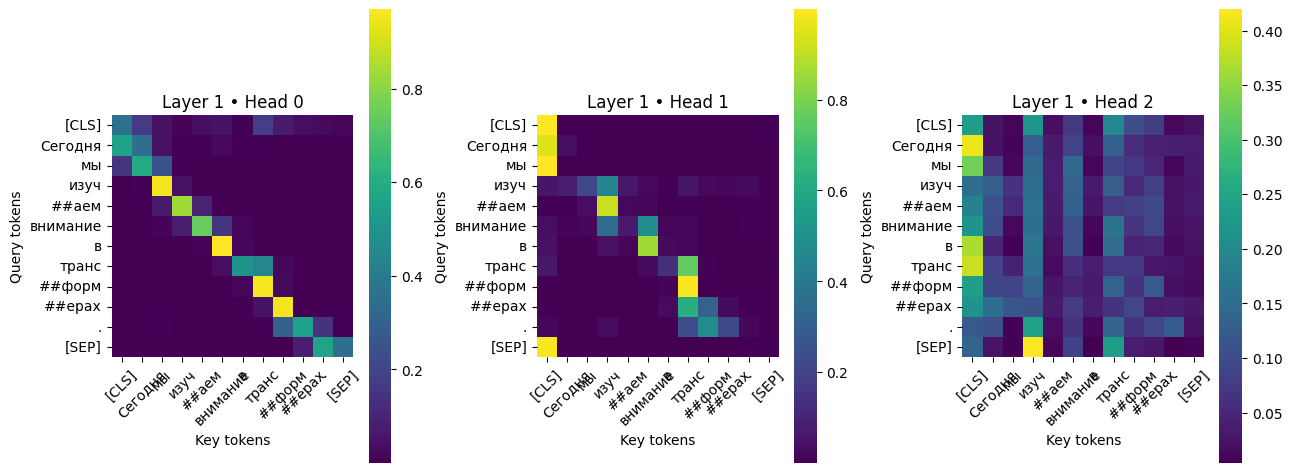

In [25]:
text = "Сегодня мы изучаем внимание в трансформерах."

draw_first_layer_attention_maps([0, 1, 2], text, finetuned_1_with_freezed_backbone)

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [26]:
MathBert = TransformerClassificationModel(base_transformer_model='tbs17/MathBert',).to(device)
rubert =TransformerClassificationModel(base_transformer_model='cointegrated/rubert-tiny2',).to(device)

In [27]:
df.problem_text[0]

'To prove that the sum of the numbers of the exact square cannot be equal to 5.'

Маски для текста To prove that the sum of the numbers of the exact square cannot be equal to 5.
cointegrated/rubert-tiny2


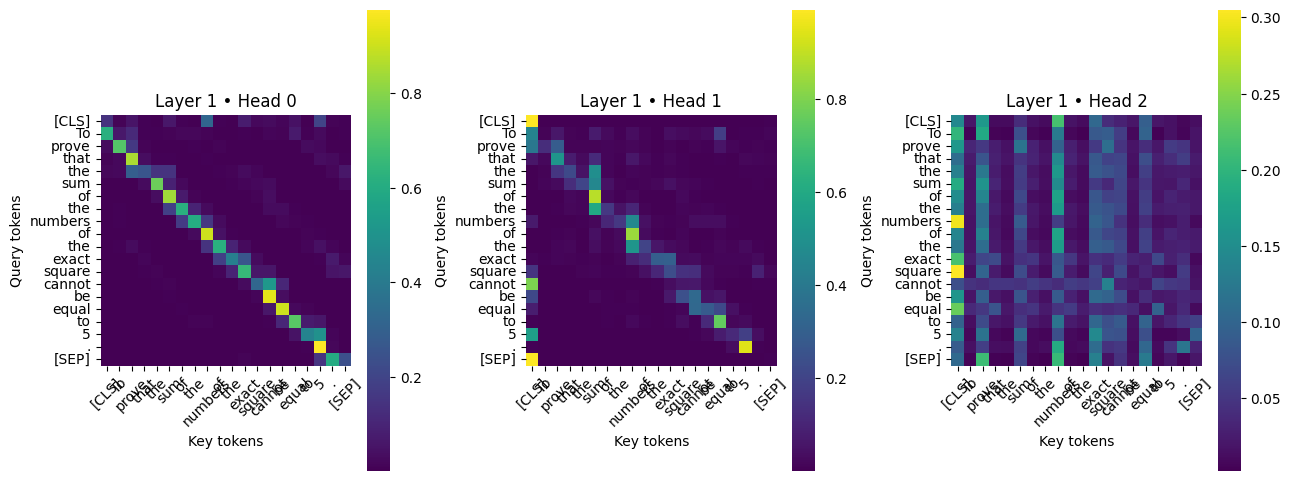

tbs17/MathBert


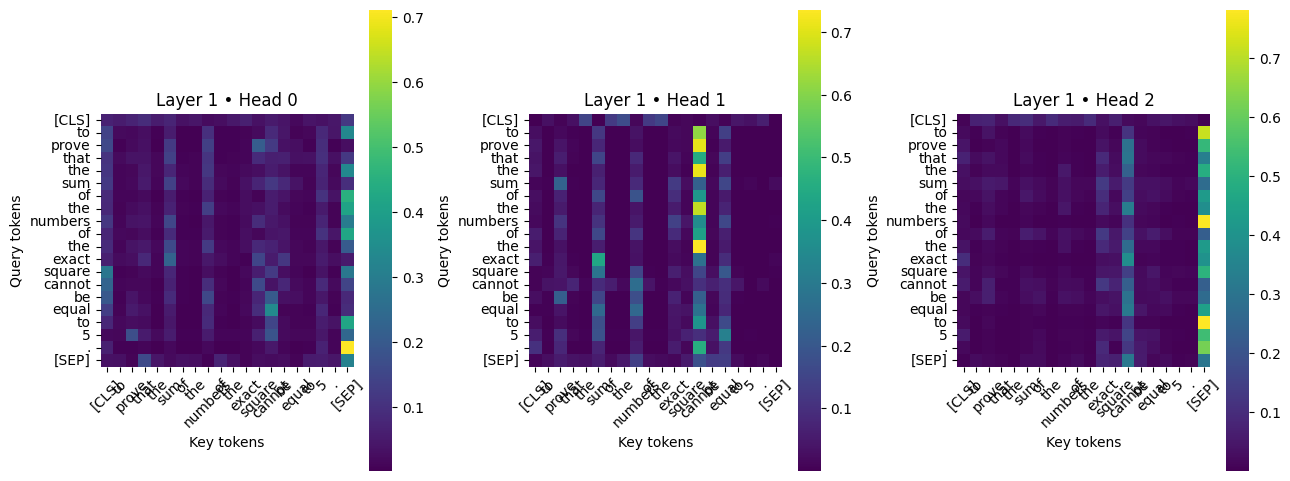

Маски для текста ( b) Will the statement of the previous challenge remain true if Petia and Wasa originally planned four natural numbers?
cointegrated/rubert-tiny2


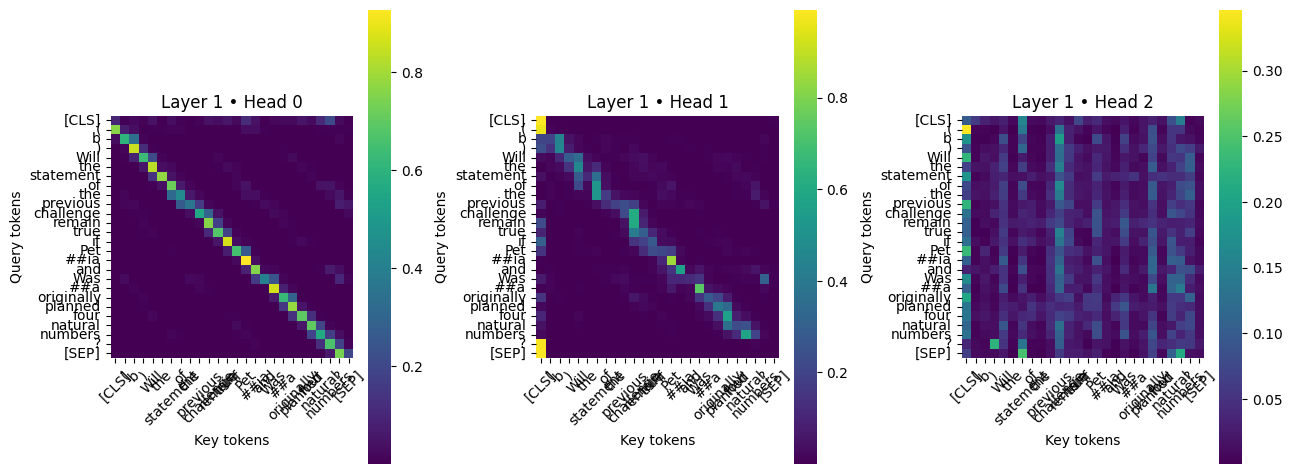

tbs17/MathBert


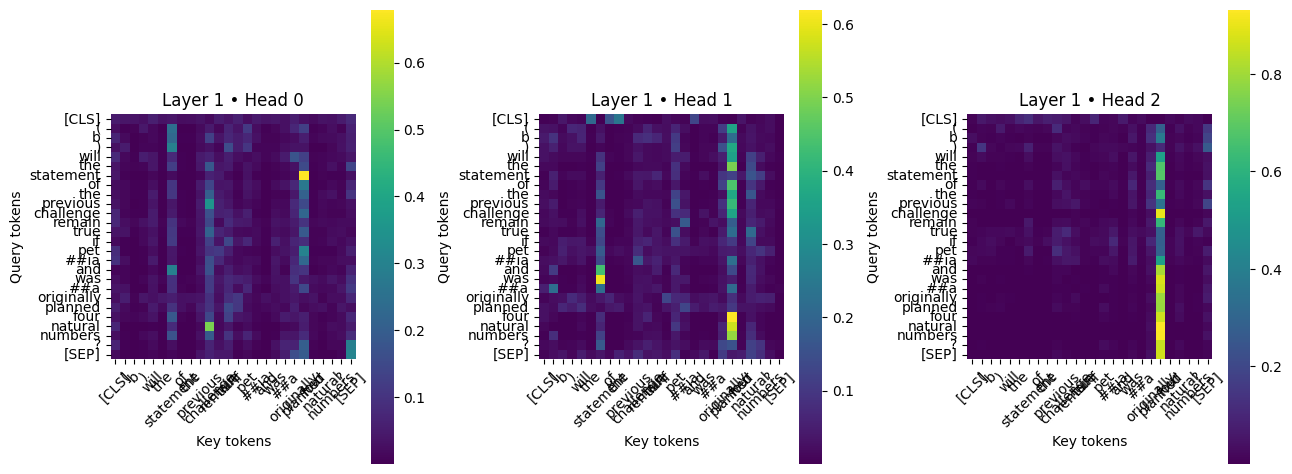

In [33]:
for text in df.problem_text[:2]:
  print(f'Маски для текста {text}')
  print(f'cointegrated/rubert-tiny2')
  draw_first_layer_attention_maps([0, 1, 2], text, rubert)
  print(f'tbs17/MathBert')
  draw_first_layer_attention_maps([0, 1, 2], text, MathBert)


Можно отследить некую логику в некоторых частях масок. Например в маске laier 1 head 1 первой модели выделяется связывающая частица "of"

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Маски для текста To prove that the sum of the numbers of the exact square cannot be equal to 5.
cointegrated/rubert-tiny2


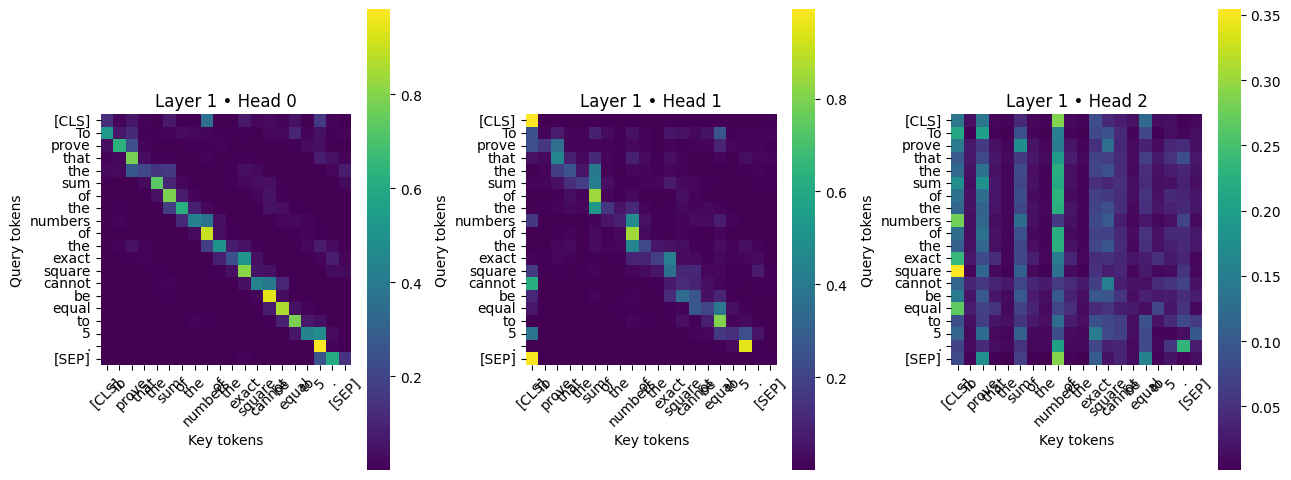

tbs17/MathBert


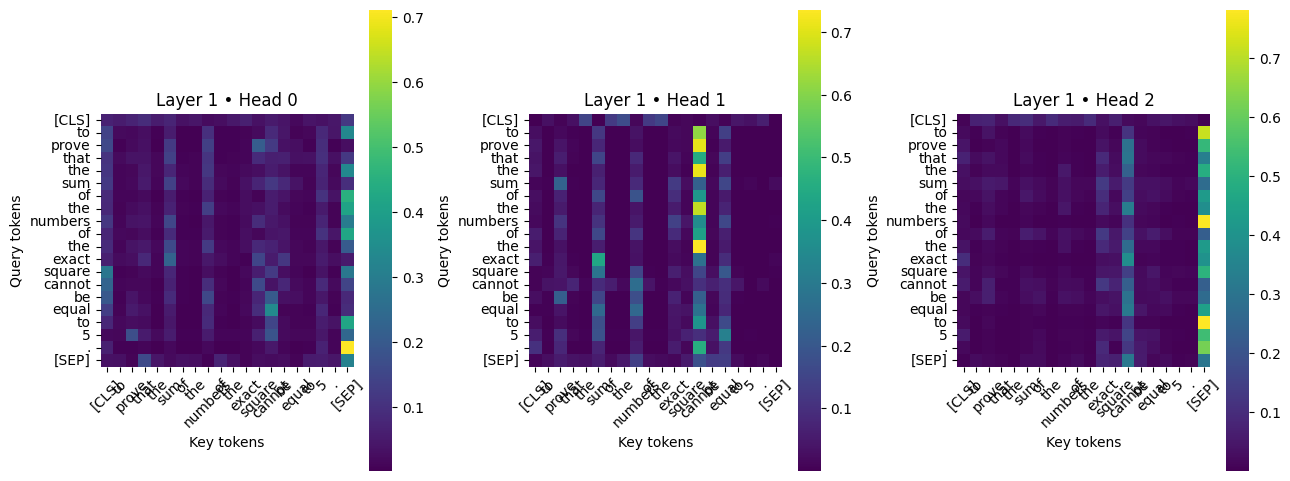

Маски для текста ( b) Will the statement of the previous challenge remain true if Petia and Wasa originally planned four natural numbers?
cointegrated/rubert-tiny2


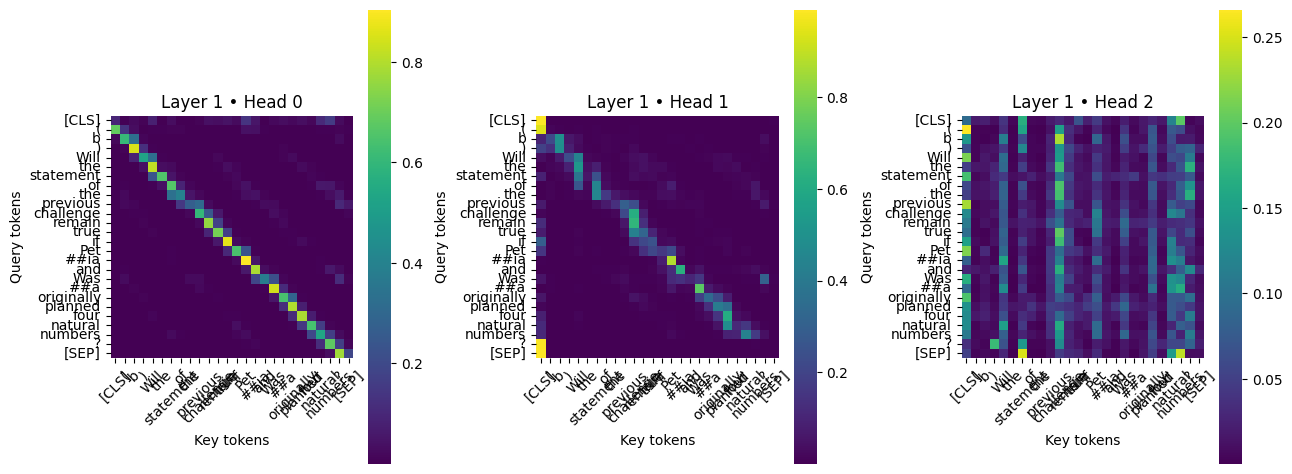

tbs17/MathBert


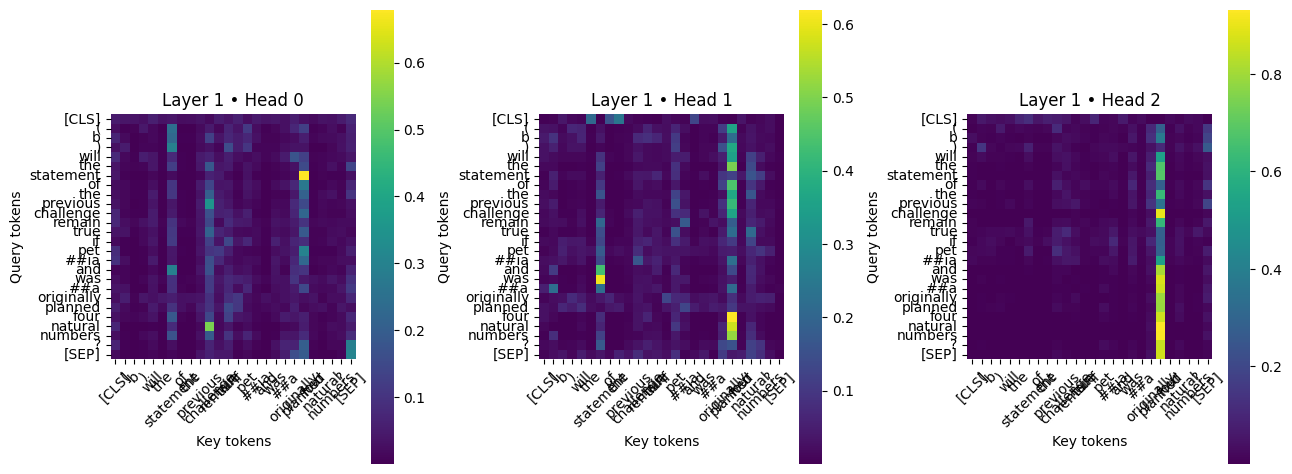

In [34]:
for text in df.problem_text[:2]:
  print(f'Маски для текста {text}')
  print(f'cointegrated/rubert-tiny2')
  draw_first_layer_attention_maps([0, 1, 2], text, finetuned_1_with_full_laier)
  print(f'tbs17/MathBert')
  draw_first_layer_attention_maps([0, 1, 2], text, finetuned_2_with_full_laier)

Изменения по сравнению с прошлыми масками существует но не значительные. Изменения показывают что трансформер обучается на новых данных